In [25]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load a grayscale image and apply the 2D Discrete Fourier Transform (DFT) to it. Visualize the original image and its frequency spectrum (magnitude). Submit the images, and explanation.

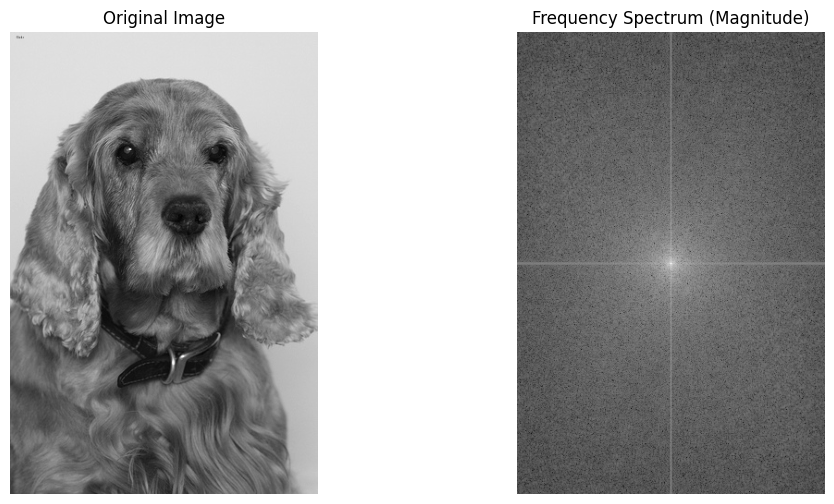

In [26]:
image_path = '../data/oxford-iiit-pet/images/english_cocker_spaniel_13.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply the 2D Discrete Fourier Transform (DFT)
dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# Plot the original image and the magnitude spectrum
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Magnitude Spectrum (Frequency Spectrum)
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Frequency Spectrum (Magnitude)')
plt.axis('off')

plt.show()

#  Implement a low-pass filter in the frequency domain to remove high-frequency noise from an image. Compare the filtered image with the original image. Submit images, and analysis of the results

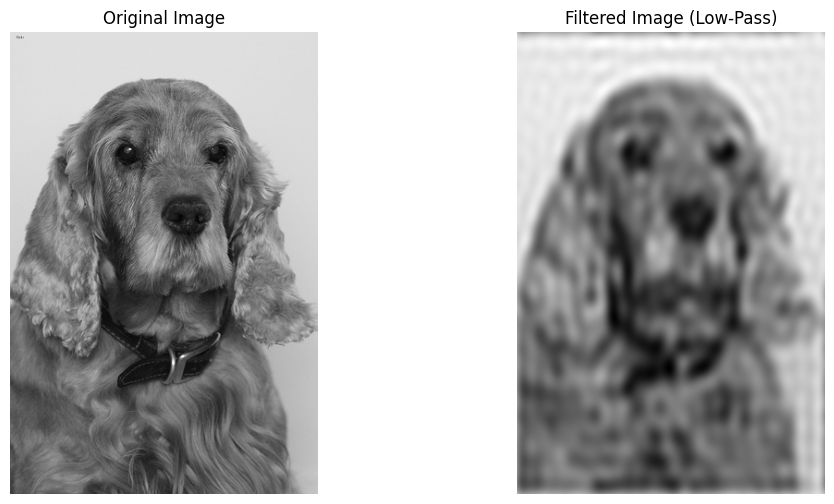

In [27]:
# Create a low-pass filter mask
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # Center of the image
radius = 20  # Adjust radius as needed for filtering
mask = np.zeros((rows, cols, 2), np.uint8)
cv2.circle(mask, (ccol, crow), radius, (1, 1), thickness=-1)  # Create a circular mask

# Apply the mask to the DFT
filtered_dft_shift = dft_shift * mask

# Inverse DFT to get the filtered image
filtered_dft_shift_ishift = np.fft.ifftshift(filtered_dft_shift)
filtered_image = cv2.idft(filtered_dft_shift_ishift)
filtered_image_magnitude = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Plot the original image and the filtered image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(filtered_image_magnitude, cmap='gray')
plt.title('Filtered Image (Low-Pass)')
plt.axis('off')

plt.show()


# Implement a high-pass filter to enhance the edges in an image. Visualize the filtered image and discuss the effects observed. Submit images, and explanation.


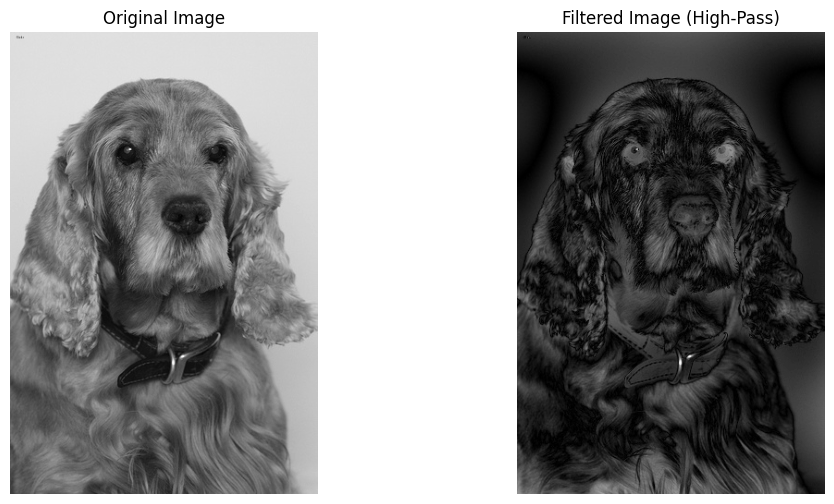

In [28]:
dft_result = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shifted = np.fft.fftshift(dft_result)  # Shift the zero frequency component to the center

# Create a mask for high-pass filtering
rows, cols = image.shape
center_row, center_col = rows // 2, cols // 2  # center

# Create a circular mask for low frequencies
radius = 2.5  # Adjust this value for desired cut-off frequency
x, y = np.ogrid[:rows, :cols]
mask = (x - center_row) ** 2 + (y - center_col) ** 2 <= radius ** 2
dft_shifted[mask] = 0  # Set the low frequencies to zero for high-pass filtering

# Apply the inverse shift before the inverse DFT
dft_shifted = np.fft.ifftshift(dft_shifted)

# Apply the inverse DFT to get the high-pass filtered image
high_pass_filtered_image = cv2.idft(dft_shifted)
high_pass_filtered_image = cv2.magnitude(high_pass_filtered_image[:, :, 0], high_pass_filtered_image[:, :, 1])

# Normalize the filtered image for display
high_pass_filtered_image = cv2.normalize(high_pass_filtered_image, None, 0, 255, cv2.NORM_MINMAX)
high_pass_filtered_image = np.uint8(high_pass_filtered_image)

# Plot the original image and the high-pass filtered image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# High-Pass Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(high_pass_filtered_image, cmap='gray')
plt.title('Filtered Image (High-Pass)')
plt.axis('off')

plt.show()


# Implement an image compression technique using Fourier Transform by selectively keeping only a certain percentage of the Fourier coefficients. Evaluate the quality of the reconstructed image as you vary the percentage of coefficients used. Submit the images, and your observations on image quality and compression ratio.

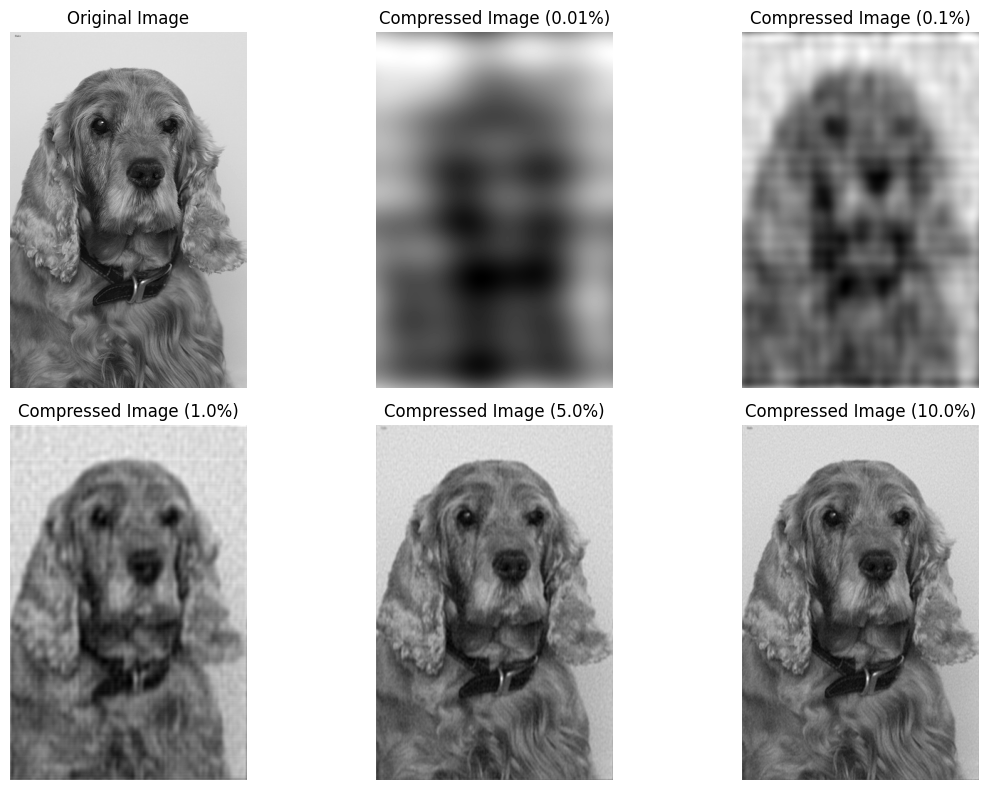

In [29]:
def compress_image_with_dft(image, keep_percentage):
    # Apply the 2D Discrete Fourier Transform (DFT)
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

    # Get the magnitude and phase of the Fourier coefficients
    magnitude_spectrum = np.abs(dft_shift)
    phase_spectrum = np.angle(dft_shift)

    # Flatten the magnitude and find the threshold for keeping the largest coefficients
    flattened_magnitude = magnitude_spectrum.flatten()
    sorted_magnitude = np.sort(flattened_magnitude)
    threshold = sorted_magnitude[int((1 - keep_percentage) * len(sorted_magnitude))]

    # Create a mask to zero out coefficients below the threshold
    magnitude_mask = magnitude_spectrum >= threshold

    # Apply the mask to keep only the selected percentage of coefficients
    compressed_dft_shift = dft_shift * magnitude_mask

    # Reconstruct the image from the compressed DFT
    compressed_dft = np.fft.ifftshift(compressed_dft_shift)  # Inverse shift
    compressed_image = cv2.idft(compressed_dft)
    compressed_image = cv2.magnitude(compressed_image[:, :, 0], compressed_image[:, :, 1])  # Get the magnitude

    return compressed_image

# Load the image
image_path = '../data/oxford-iiit-pet/images/english_cocker_spaniel_13.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Compress the image with different percentages of Fourier coefficients
percentages = [0.0001, 0.001, 0.01, 0.05, 0.1]  # 10%, 30%, 50%
compressed_images = [compress_image_with_dft(image, p) for p in percentages]

# Plot the original image and the compressed images
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Compressed Images
for i, (p, comp_img) in enumerate(zip(percentages, compressed_images), start=2):
    plt.subplot(2, 3, i)
    plt.imshow(comp_img, cmap='gray')
    plt.title(f'Compressed Image ({p*100}%)')
    plt.axis('off')

plt.tight_layout()
plt.show()
